# Rumor Source Detection on Directed Graph

In [1]:
import math
import igraph as ig
import matplotlib.pyplot as plt
import heapq
import sys
sys.path.append("../src")

from src import rate_ss, rate_uc, rate_ma, rate_ms, clean_disconnected_components, draw_graph, rho_ms, greedy_forward, lazy_greedy_forward

# Backward Elimination Algorithm for Finding Feasible Source

We implemented the multi-source multicast rate and used Listing 1 backward elimination algorithm to find feasible set of sources. To demonstrate, we used the same butterfly network in the paper while relabeled the nodes from $0$ due to the `iGraph` limits.

## Multi-source multicast rate by nodes contraction

For directed networks, the maximum multi-source multicast rate is defined as 
\begin{equation}\rho_{\text{ms}}(S,A) := \max \{r(S) | r_{V} \in \mathcal{R}^{V}_{+}, r(B) < \lambda(B, V\setminus B) \quad \forall B \subseteq V:B \not\supseteq A\},\end{equation}
where $r_V:=(r_i|i\in V)$ and $r(B):=\sum_{u\in B} r_u$.

To calculate the mincut function, we use the max-flow min-cut result from network coding and calculate the minimize the $\lambda(B, V\setminus B)$.
\begin{align}
    \min_{B \subseteq V:B \not\supseteq A} \lambda(B, V\setminus B) &= \min_{j \in A} \min_{B \subseteq V \setminus \{j\}: B \not\supseteq A} \lambda(B, \{j\}) \\
    &= \min_{j \in A} \text{mincut} (s, j),
\end{align}
where $s$ is the node by node contraction in $B$. The min-cut is calculated by `iGraph.mincut` method with iGraph package.

In [ ]:
def rate_ms(graph, S, A):
    if not A:
        return float("inf")
    if S.issubset(A):
        return 0.0

    new_node = graph.vcount()
    flows = []
    capacities = graph.es["capacity"]

    if len(S) == 1:
        s = list(S)[0]
        for j in A:
            min_cut_value = graph.mincut(s, j, capacity=capacities).value
            flows.append(min_cut_value)
        return min(flows)

    for j in A:
        mapping_vector = [i if i not in S - {j} else new_node for i in range(new_node)]
        contracted_graph = graph.copy()
        contracted_graph.contract_vertices(mapping_vector, combine_attrs={"capacity": sum})
        min_cut_value = contracted_graph.mincut(new_node, j, capacity=contracted_graph.es["capacity"]).value
        flows.append(min_cut_value)

    return min(flows)

Backward elimiation algorithm according to Listing 1 in the paper.

In [2]:
# Backward elimination algorithm
def feasible_source(graph, r, A, rate_fn):
    """
    Backward elimination algorithm to find minimal source set S
    such that rate_fn(S, A) ≥ r.

    Parameters
    ----------
    graph : igraph.Graph
        Input graph with capacity attribute.
    r : float
        Required minimum multicast rate.
    A : set[int]
        Sink node indices.
    rate_fn : callable
        Function (graph, S, A) → float. Must be monotonic.

    Returns
    -------
    S : set[int] or None
        Feasible source set if one exists, else None.
    """
    if r <= 0:
        raise ValueError("Rate r must be positive")

    V = {v.index for v in graph.vs}

    if rate_fn(graph, V, A) < r:
        return None

    S = V.copy()
    for u in V:
        if rate_fn(graph, S - {u}, A) >= r:
            S.remove(u)

    return S

Test on the butterfly network.

IGRAPH D--- 6 7 -- 
+ attr: capacity (e)


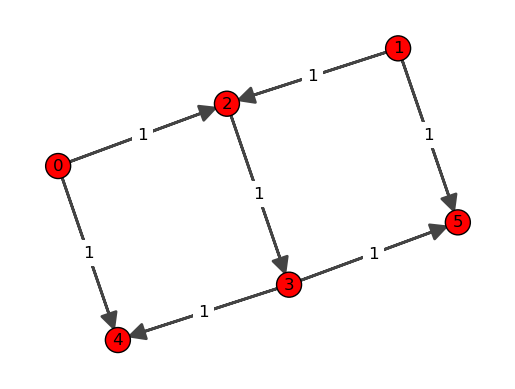

In [52]:
if __name__ == "__main__":
    # Create a network
    b = ig.Graph(directed=True)
    b.add_vertices(6)
    b.add_edges([(0, 4), (0, 2), (1, 2), (1, 5), (2, 3), (3, 4), (3, 5)]) 
    b.es["capacity"] = [1, 1, 1, 1, 1, 1, 1]

    print(b.summary())
    
    draw_graph(b)

In [4]:
source_set = [{0}, {1}, {2}, {3}, {0, 1}, {1, 2}, {0, 1, 2}, {4}, {0, 4}, {4, 5}, {0, 1, 2, 3, 4, 5}]
for sets in source_set:
    print(f'The multi-source multicast rate is {rate_ms(b, sets, {4, 5})} for the source group {sets} and sink group {{4, 5}}')

The multi-source multicast rate is 1.0 for the source group {0} and sink group {4, 5}
The multi-source multicast rate is 1.0 for the source group {1} and sink group {4, 5}
The multi-source multicast rate is 1.0 for the source group {2} and sink group {4, 5}
The multi-source multicast rate is 1.0 for the source group {3} and sink group {4, 5}
The multi-source multicast rate is 2.0 for the source group {0, 1} and sink group {4, 5}
The multi-source multicast rate is 1.0 for the source group {1, 2} and sink group {4, 5}
The multi-source multicast rate is 2.0 for the source group {0, 1, 2} and sink group {4, 5}
The multi-source multicast rate is 0.0 for the source group {4} and sink group {4, 5}
The multi-source multicast rate is 1.0 for the source group {0, 4} and sink group {4, 5}
The multi-source multicast rate is 0.0 for the source group {4, 5} and sink group {4, 5}
The multi-source multicast rate is 2.0 for the source group {0, 1, 2, 3, 4, 5} and sink group {4, 5}


In [5]:
# Define sink group A
sinks = {4, 5}

# Define the rate limit r with a list
r_list = [0.1, 1, 1.5, 2, 3]

# Find the feasible source group
for r in r_list:
    feasible_sources = feasible_source(b, r, sinks, rate_ms)
    print(f"If rate limit is {r}, the feasible source set is {feasible_sources}")

If rate limit is 0.1, the feasible source set is {3}
If rate limit is 1, the feasible source set is {3}
If rate limit is 1.5, the feasible source set is {0, 1}
If rate limit is 2, the feasible source set is {0, 1}
If rate limit is 3, the feasible source set is None


### Test with more synthetic graphs

In [12]:
### Barabasi-Albert graph
g_ba = ig.Graph.Barabasi(n=20, m=2, directed=True)
g_ba = clean_disconnected_components(g_ba)
g_ba.es["capacity"] = [1] * g_ba.ecount()


### Watts-Strogatz graph (small-world)
g_ws = ig.Graph.Watts_Strogatz(dim=1, size=20, nei=3, p=0.5)
g_ws = clean_disconnected_components(g_ws)
g_ws = g_ws.as_directed(mutual=False)
g_ws.es["capacity"] = [1] * g_ws.ecount()

### Erdos-Renyi graph
g_er = ig.Graph.Erdos_Renyi(n=20, p=0.2, directed=True)
g_er.es["capacity"] = [1] * g_er.ecount()
g_er = clean_disconnected_components(g_er)

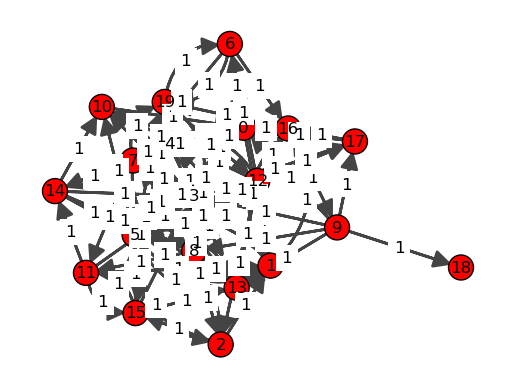

In [36]:
draw_graph(g_er)

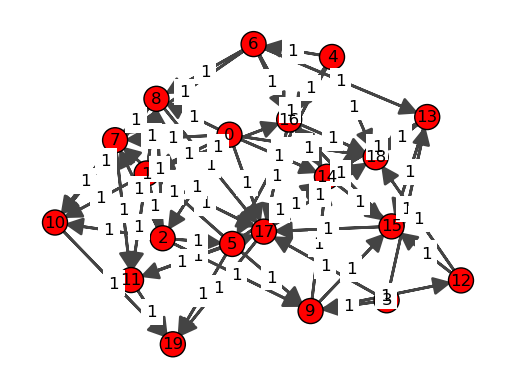

In [27]:
draw_graph(g_ws)

In [49]:
graphs = {
    "Barabási-Albert (BA)": g_ba,
    "Watts-Strogatz (WS)": g_ws,
    "Erdős-Rényi (ER)": g_er,
}

sink_sets = {
    "Barabási-Albert (BA)": {0, 1},         # early nodes
    "Watts-Strogatz (WS)": {18, 19},        # tail end
    "Erdős-Rényi (ER)": {16, 19},           # random tail nodes
}

# Define target rates and fixed sink set
target_rates = [0.5, 1.0, 2.0, 3.0, 6.0]
results = []

for name, graph in graphs.items():
    A = sink_sets[name]
    for r in target_rates:
        S = feasible_source(graph, r, A, rate_fn=rate_ms)
        results.append({
            "Graph": name,
            "Target Rate": r,
            "Feasible": S is not None,
            "Source Set Size": len(S) if S else None,
            "Source Set": sorted(S) if S else None
        })

import pandas as pd
df_results = pd.DataFrame(results)
df_results

,Graph,Target Rate,Feasible,Source Set Size,Source Set
0,Barabási-Albert (BA),0.5,True,1.0,[19]
1,Barabási-Albert (BA),1.0,True,1.0,[19]
2,Barabási-Albert (BA),2.0,True,1.0,[18]
3,Barabási-Albert (BA),3.0,True,3.0,"[17, 18, 19]"
4,Barabási-Albert (BA),6.0,True,5.0,"[11, 12, 15, 17, 18]"
5,Watts-Strogatz (WS),0.5,True,1.0,[17]
6,Watts-Strogatz (WS),1.0,True,1.0,[17]
7,Watts-Strogatz (WS),2.0,True,2.0,"[11, 16]"
8,Watts-Strogatz (WS),3.0,True,3.0,"[10, 11, 13]"
9,Watts-Strogatz (WS),6.0,False,NaN,None


# Forward Search Algorithm

We applied the Listing 2, greedy forward search algorithm, and further extend to Listing 3, the lazy-greedy variant, to show the scalability. Since the unicast case is submodular and the greedy algorithm to solve submodular function maximization can achieve $1-1/e$ guarantee, we mainly talk about the maximum unicast rate.

## Maximum unicast rate

If the source nodes and sink nodes can collude respectively, the capacity becomes the maximum unicast rate
\begin{equation}
    \rho_{\text{uc}}(S,A) := \min_{B\subseteq V \setminus A: S\subseteq B} \lambda(B, V\setminus B).
\end{equation}
The calculation of the mincut function is similar to the single source multicast rate.

In [61]:
source_set = [{0}, {1}, {2}, {3}, {0, 1}, {1, 2}, {0, 1, 2}]
for sets in source_set:
    print(f'The multi-source unicast rate is {rate_uc(b, sets, {4, 5})} for the source group {sets} and sink group {{4, 5}}')

### Errors should appear since S is not disjoint from A
# source_set = [{4}, {0, 4}, {4, 5}, {0, 1, 2, 3, 4, 5}]
# for sets in source_set:
#     print(f'The multi-source unicast rate is {rate_uc(b, sets, {4, 5})} for the source group {sets} and sink group {{4, 5}}')

The multi-source unicast rate is 1.0 for the source group {0} and sink group {4, 5}
The multi-source unicast rate is 1.0 for the source group {1} and sink group {4, 5}
The multi-source unicast rate is 1.0 for the source group {2} and sink group {4, 5}
The multi-source unicast rate is 1.0 for the source group {3} and sink group {4, 5}
The multi-source unicast rate is 2.0 for the source group {0, 1} and sink group {4, 5}
The multi-source unicast rate is 1.0 for the source group {1, 2} and sink group {4, 5}
The multi-source unicast rate is 2.0 for the source group {0, 1, 2} and sink group {4, 5}


Use greedy forward search to find the approximate rate value and the source set.

In [53]:
### For greedy algorithm, the approximate rate is 1.0 and the selected source set is {0, 1}.
# sinks
A = {4, 5}

# budget
for k in range(1, 7):
    r_hat, S = greedy_forward(b, A, k, rate_uc)
    print(f"Approximate rate ρ̂({k}) = {r_hat:.2f} for source set S = {S}")

Approximate rate ρ̂(1) = 1.00 for source set S = {0}
Approximate rate ρ̂(2) = 2.00 for source set S = {0, 1}
Approximate rate ρ̂(3) = 2.00 for source set S = {0, 1, 2}
Approximate rate ρ̂(4) = 2.00 for source set S = {0, 1, 2, 3}
Approximate rate ρ̂(5) = 2.00 for source set S = {0, 1, 2, 3}
Approximate rate ρ̂(6) = 2.00 for source set S = {0, 1, 2, 3}


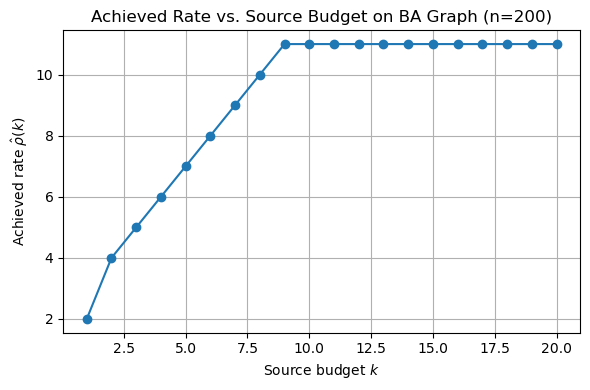

In [ ]:
node_count = 200
g_ba = ig.Graph.Barabasi(n=node_count, m=2, directed=True)
g_ba = clean_disconnected_components(g_ba)
g_ba.es["capacity"] = [1] * g_ba.ecount()
A = {0, 1}

max_k = 20
k_vals = list(range(1, max_k + 1))
achieved_rates = []

for k in k_vals:
    r_hat, _ = lazy_greedy_forward(g_ba, A, k, rate_uc)
    achieved_rates.append(r_hat)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(k_vals, achieved_rates, marker='o')
plt.xlabel("Source budget $k$")
plt.ylabel("Achieved rate")
plt.title("Achieved Rate vs. Source Budget on BA Graph (n=200)")
plt.grid(False)
plt.tight_layout()
plt.show()

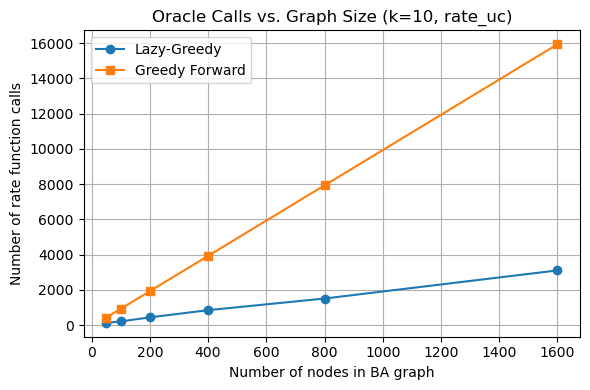

In [ ]:
class RateCounter:
    def __init__(self, rate_fn):
        self.rate_fn = rate_fn
        self.call_count = 0

    def __call__(self, graph, S, A):
        self.call_count += 1
        return self.rate_fn(graph, S, A)

node_counts = [50, 100, 200, 400, 800, 1600]
k = 10
calls_lazy, calls_plain = [], []

for n in node_counts:
    g_ba = ig.Graph.Barabasi(n=n, m=3, directed=True)
    g_ba = clean_disconnected_components(g_ba)
    g_ba.es["capacity"] = [1] * g_ba.ecount()
    A = {0, 1}
    counter_lazy = RateCounter(rate_uc)
    lazy_greedy_forward(g_ba, A, k, rate_fn=counter_lazy)
    calls_lazy.append(counter_lazy.call_count)

    counter_plain = RateCounter(rate_uc)
    greedy_forward(g_ba, A, k, rate_fn=counter_plain)
    calls_plain.append(counter_plain.call_count)

plt.figure(figsize=(6, 4))
plt.plot(node_counts, calls_lazy, label="Lazy-Greedy", marker='o')
plt.plot(node_counts, calls_plain, label="Greedy Forward", marker='s')
plt.xlabel("Number of nodes in BA graph")
plt.ylabel("Number of rate function calls")
plt.title("Oracle Calls vs. Graph Size (k=10, rate_uc)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()